In [11]:
from imm import imm
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer

np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[[ 1.51861254 -0.5622498   0.23205254 -1.16959318  1.91390522  0.80899739
   1.03481896 -0.65956311  1.22488398  0.25171685  0.36217728  1.84791957
   1.01300893]
 [ 0.24628963 -0.49941338 -0.82799632 -2.49084714  0.01814502  0.56864766
   0.73362894 -0.82071924 -0.54472099 -0.29332133  0.40605066  1.1134493
   0.96524152]
 [ 0.19687903  0.02123125  1.10933436 -0.2687382   0.08835836  0.80899739
   1.21553297 -0.49840699  2.13596773  0.26901965  0.31830389  0.78858745
   1.39514818]
 [ 1.69154964 -0.34681064  0.4879264  -0.80925118  0.93091845  2.49144552
   1.46652465 -0.98187536  1.03215473  1.18606801 -0.42754369  1.18407144
   2.33457383]
 [ 0.29570023  0.22769377  1.84040254  0.45194578  1.28198515  0.80899739
   0.66335127  0.22679555  0.40140444 -0.31927553  0.36217728  0.44960118
  -0.03787401]
 [ 1.48155459 -0.51736664  0.30515936 -1.28970717  0.86070511  1.56209322
   1.36612798 -0.17609475  0.66421706  0.73186953  0.40605066  0.33660575
   2.23903902]
 [ 1.71625494 -0.418623

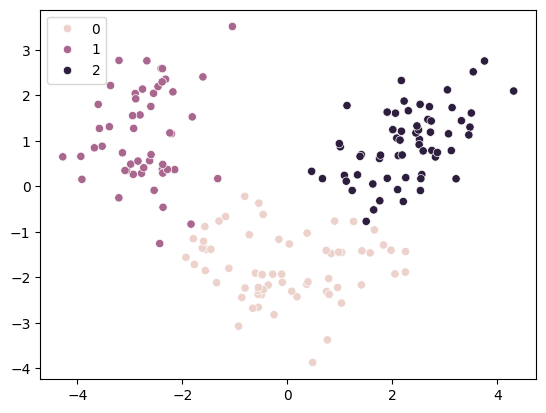

In [18]:
dims = 2
n = 10000
k = 3
min_impurity_decrease = 0.001
threshold_change = 0.0000001
robustness_factor = 0.7

# X, _y = make_blobs(centers=k, cluster_std=1.2, n_features=dims, n_samples=n)
data = load_wine()
X, _y = data.data, data.target

# Normalize data
X = StandardScaler().fit_transform(X)

model = KMeans(n_clusters=k)
model.fit(X)
centers = model.cluster_centers_
y = model.predict(X)

pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y, legend='full')

#initialize with 2 clusters
# X = np.array([[1, 2], [1, 4], [1, 0],
#               [10, 2], [10, 4], [10, 0]])


dims = X.shape[1]
n = X.shape[0]
print(X[:10])

In [19]:
instance_index = y.argmin()
instance = X[instance_index]
target_class = 2
target_point = centers[target_class, :]

print("")
print(f"Instance class: {y[instance_index]}, point: {instance}")
print(f"Target center class: {target_class}, point: {target_point}\n")


Instance class: 0, point: [-0.77898029 -1.25345042 -3.67916223 -2.67101814 -0.82441507 -0.50491447
 -1.46505818 -0.65956311 -2.05151334 -1.34446639  0.40605066 -1.11821035
 -0.72254016]
Target center class: 2, point: [ 0.83523208 -0.30380968  0.36470604 -0.61019129  0.5775868   0.88523736
  0.97781956 -0.56208965  0.58028658  0.17106348  0.47398365  0.77924711
  1.12518529]



# SKLearn Decision Tree Classifier

In [20]:
clf = DecisionTreeClassifier(random_state=42, min_impurity_decrease=min_impurity_decrease)
clf.fit(X, y)
print(f"Accuracy: {clf.score(X, y)}")

n_leaves = clf.get_n_leaves()
n_total_nodes = clf.tree_.node_count
n_internal_nodes = n_total_nodes - n_leaves

tree_model = clf.tree_
feature = tree_model.feature
threshold = tree_model.threshold
parent = np.full(n_total_nodes, -1, dtype=int)
for i in range(n_total_nodes):
    if tree_model.children_left[i] != -1:
        parent[tree_model.children_left[i]] = i
    if tree_model.children_right[i] != -1:
        parent[tree_model.children_right[i]] = i

# print("Parent list: ", parent)


print(f"Number of leaves: {n_leaves}")
print(f"Number of nodes: {n_total_nodes}")
print(f"Number of internal nodes: {n_internal_nodes}")

# Find all leafs that are of the target class
target_leafs = np.array([x for x in range(n_total_nodes) if tree_model.children_left[x] == -1 and np.argmax(tree_model.value[x]) == target_class])
print("Leaf Ids for target class: ", target_leafs)

print(f"Instance class: {y[instance_index]}, point: {instance}")
print(f"Target center class: {target_class}, point: {target_point}")

inst = np.array([instance])
targ = np.array([target_point])
inst = inst.astype(np.float32)
targ = targ.astype(np.float32)


inst_node_indicator = np.array(tree_model.decision_path(inst).todense())[0]
inst_leaf_id = tree_model.apply(inst)

target_node_indicator = np.array(tree_model.decision_path(targ).todense())[0]
target_leaf_id = tree_model.apply(targ)

# path_len = min(inst_node_indicator.shape[0], target_node_indicator.shape[0])
# path_equality = inst_node_indicator[:path_len] & target_node_indicator[:path_len]
# last_equal_parent = np.nonzero(path_equality)[0].max()
# print("Index in tree of parent equality: ", last_equal_parent)

# temp = np.nonzero(target_node_indicator)[0]
# temp = temp[temp >= last_equal_parent]

# path_of_changes = set(temp)

# print("-----------------------------------------------------------------------------------------")
# print("Path of changes: ", path_of_changes)

# cf = instance.copy() # counterfactual

# curr_node = last_equal_parent
# i = 0
# print("  ", cf)
# while len(path_of_changes) > 1:
#     path_of_changes.remove(curr_node)
#     if tree_model.children_left[curr_node] in path_of_changes:
#         print(f"Change {i}: Left child")
#         if cf[feature[curr_node]] >= threshold[curr_node]:
#             cf[feature[curr_node]] = threshold[curr_node] - 0.0001
#         curr_node = tree_model.children_left[curr_node]
#     elif tree_model.children_right[curr_node] in path_of_changes:
#         print(f"Change {i}: Right child")
#         if cf[feature[curr_node]] < threshold[curr_node]:
#             cf[feature[curr_node]] = threshold[curr_node]
#         curr_node = tree_model.children_right[curr_node]
#     else:
#         print("CHILD COULD NOT BE LOCATED!!!!!")
#         break
#     i += 1
#     print("  ", cf)

# print(f"Counterfactual prediction: {clf.predict([cf])}")

Accuracy: 1.0
Number of leaves: 12
Number of nodes: 23
Number of internal nodes: 11
Leaf Ids for target class:  [13 16 22]
Instance class: 0, point: [-0.77898029 -1.25345042 -3.67916223 -2.67101814 -0.82441507 -0.50491447
 -1.46505818 -0.65956311 -2.05151334 -1.34446639  0.40605066 -1.11821035
 -0.72254016]
Target center class: 2, point: [ 0.83523208 -0.30380968  0.36470604 -0.61019129  0.5775868   0.88523736
  0.97781956 -0.56208965  0.58028658  0.17106348  0.47398365  0.77924711
  1.12518529]


## Find Counterfactual for each leaf with target class

In [34]:
cfs = np.zeros(shape=(target_leafs.shape[0], dims))
cfs_prime = np.zeros(shape=(target_leafs.shape[0], dims))


for j,l in enumerate(target_leafs):
    print("Instance ID: ", inst_leaf_id)
    print("Target node ID: ", l)
    # print("parent list: ", parent)

    target_node_indicator = np.zeros(shape=(n_total_nodes), dtype=int)
    curr_node = l
    # print("Leaf node: ", curr_node)
    while parent[curr_node] != -1:
        target_node_indicator[curr_node] = 1
        curr_node = parent[curr_node]
        # print("Parent node: ", curr_node)

    target_node_indicator[curr_node] = 1


    inst = np.array([instance])
    inst = inst.astype(np.float32)


    inst_node_indicator = np.array(tree_model.decision_path(inst).todense())[0]


    path_len = min(inst_node_indicator.shape[0], target_node_indicator.shape[0])
    path_equality = inst_node_indicator[:path_len] & target_node_indicator[:path_len]
    last_equal_parent = np.nonzero(path_equality)[0].max()
    print("Index in tree of parent equality: ", last_equal_parent)

    temp = np.nonzero(target_node_indicator)[0]
    temp = temp[temp >= last_equal_parent]

    path_of_changes = set(temp)

    print("-----------------------------------------------------------------------------------------")
    # print("Instance path: ", inst_node_indicator)
    # print("Target path: ", target_node_indicator)
    # print("Path of changes: ", path_of_changes)

    cf = instance.copy() # counterfactual

    curr_node = last_equal_parent
    i = 0
    while len(path_of_changes) > 1:
        # print("  CF:  ", cf)
        path_of_changes.remove(curr_node)
        if tree_model.children_left[curr_node] in path_of_changes:
            # print(f"Change {i}: Left child")
            if cf[feature[curr_node]] >= threshold[curr_node]:
                cf[feature[curr_node]] = threshold[curr_node] - threshold_change
            curr_node = tree_model.children_left[curr_node]
        elif tree_model.children_right[curr_node] in path_of_changes:
            # print(f"Change {i}: Right child")
            if cf[feature[curr_node]] < threshold[curr_node]:
                cf[feature[curr_node]] = threshold[curr_node] + threshold_change
            curr_node = tree_model.children_right[curr_node]
        else:
            print("CHILD COULD NOT BE LOCATED!!!!!")
            break
        i += 1

    # print("  CF:  ", cf)
    print("")
    print(f"Counterfactual prediction: {clf.predict([cf])}")
    assert clf.predict([cf]) == target_class
    cf = np.array(cf)
    cf = cf.astype(np.float32)
    change = cf - instance
    change[change < 0.00001] = 0
    print(f"Counterfactual change: {change}")
    print(f"Counterfactual Tree index: {tree_model.apply(np.array([cf]))}")

    cfs_prime[j] = cf
    for i in range(dims):
        if change[i] != 0:
            change_prime = instance[i] + change[i] + ((target_point[i] - cf[i]) * robustness_factor)
            temp_cf = cfs_prime[j].copy()
            temp_cf[i] = change_prime
            # print(f"Pred: ", clf.predict([temp_cf2]))
            if clf.predict([temp_cf]) == target_class:
                cfs_prime[j][i] = change_prime
    print("-----------------------------------------------------------------------------------------")
    cfs[j] = cf

print("Instance: ")
print(instance)
print("Counterfactuals: ")
print(cfs)
print("Counterfactuals': ")
print(cfs_prime)

Instance ID:  [4]
Target node ID:  13
Index in tree of parent equality:  1
-----------------------------------------------------------------------------------------

Counterfactual prediction: [2]
Counterfactual change: [0.9943884  0.         0.         0.         0.         0.
 0.1756942  0.         0.         0.         0.         0.52260396
 0.        ]
Counterfactual Tree index: [13]
-----------------------------------------------------------------------------------------
Instance ID:  [4]
Target node ID:  16
Index in tree of parent equality:  1
-----------------------------------------------------------------------------------------

Counterfactual prediction: [2]
Counterfactual change: [0.         0.         5.3550745  0.         0.         0.
 0.         0.         0.         0.         0.         0.52260396
 0.        ]
Counterfactual Tree index: [16]
-----------------------------------------------------------------------------------------
Instance ID:  [4]
Target node ID:  22


In [35]:
print("Instance class: ", clf.predict([instance]))
print("Counterfactuals class: ", clf.predict(cfs))

Instance class:  [0]
Counterfactuals class:  [2 2 2]


ValueError: X has 2 features, but DecisionTreeClassifier is expecting 13 features as input.

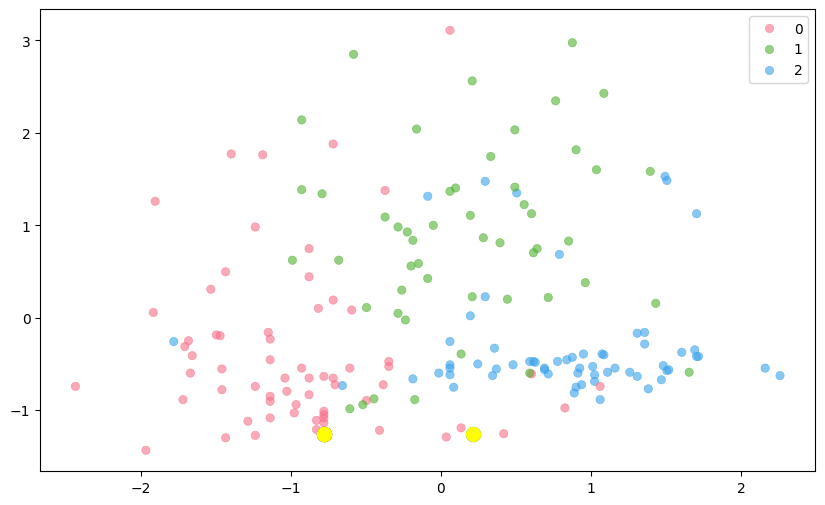

In [22]:
# Assuming X, y, instance, target_point, cf, and tree_model are already defined

# Plot the data points and clusters
plt.figure(figsize=(10, 6))
unique_labels = np.unique(y)
palette = sns.color_palette("husl", len(unique_labels))  # Use a distinct color palette
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=palette, alpha=0.6, edgecolor=None, legend='full')

# Plot the initial point
plt.scatter(instance[0], instance[1], color='red', s=100, label='Initial Point')

# Plot the counterfactual
for cf in cfs:
    plt.scatter(cf[0], cf[1], color='green', s=100, label='Counterfactual')

for cf in cfs_prime:
    plt.scatter(cf[0], cf[1], color='yellow', s=100, label='C\'')

# Plot the decision boundaries
plot_step = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('Clusters, Decision Boundaries, Initial Point, and Counterfactual')
plt.show()

## Visualize tree and path example

Instance leaf id: [4]
Rules used to predict sample 0:

decision node 0 : (X_test[0, 12] = -0.7225401401519775) <= 0.025815866887569427)
decision node 1 : (X_test[0, 11] = -1.1182103157043457) <= -0.5956065058708191)
decision node 2 : (X_test[0, 9] = -1.3444663286209106) <= -0.5333976745605469)
decision node 3 : (X_test[0, 1] = -1.2534503936767578) <= 0.28604187071323395)


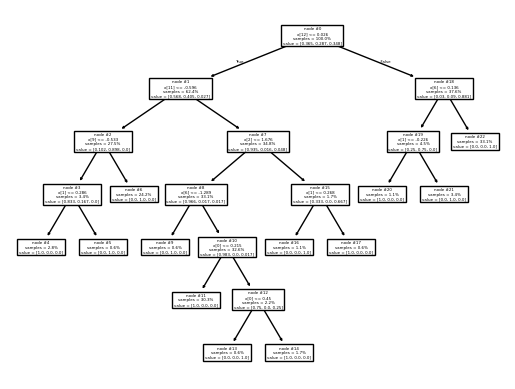

In [24]:
# Following code is from: https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

inst_node_indicator = tree_model.decision_path(inst)
inst_leaf_id = tree_model.apply(inst)
print(f"Instance leaf id: {inst_leaf_id}")
# print(f"Target leaf id: {target_leaf_id}")


# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
sample_id = 0
node_index = inst_node_indicator.indices[
    inst_node_indicator.indptr[sample_id] : inst_node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if inst_leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if inst[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=inst[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

tree.plot_tree(clf, proportion=True, node_ids=True, impurity=False)
# plt.savefig('fig1.png', dpi = 3000) # Save tree for inspection
plt.show()

# IMM

In [39]:
imm_model = imm()
imm_model.fit(X, y, centers)

print(imm_model.write_tree())

instance_path = imm_model.get_path(instance)
target_path = imm_model.get_path(target_point)
print(f"Instance path: {instance_path}")
print(f"Target path: {target_path}\n")

path_len = min(len(instance_path), len(target_path))
path_equality = instance_path[:path_len] == target_path[:path_len]
last_equal_parent = np.nonzero(path_equality)[0].max()
print("Index in tree of parent equality: ", last_equal_parent)
path_of_changes = target_path[last_equal_parent:]
# print("Path of changes: ", path_of_changes)

cf = instance.copy()

for i in range(len(path_of_changes) - 1):
    print(f"Change {i}:")
    curr_node = path_of_changes[i]
    if curr_node.left == path_of_changes[i+1]:
        if cf[curr_node.feature] >= curr_node.threshold:
            cf[curr_node.feature] = curr_node.threshold - threshold_change
    else:
        if cf[curr_node.feature] < curr_node.threshold:
            cf[curr_node.feature] = curr_node.threshold + threshold_change

print("Instance: ", instance)
print("Counterfactual: ", cf)
print("")
print("Original class: ", imm_model.predict(instance))
print("Counterfactual class: ", imm_model.predict(cf))

├── L0: f12 < 0.18566955148827075
│   ├── L1: f11 < -0.5108237186416438
│   │   ├── L2, C: 1
│   │   └── L2, C: 0
│   └── L1, C: 2

Instance path: [<imm.Node object at 0x7a19fdfc8760> <imm.Node object at 0x7a19fdfc8910>
Target path: [<imm.Node object at 0x7a19fdfc8760> <imm.Node object at 0x7a19fdfc88e0>]

Index in tree of parent equality:  0
Change 0:
Instance:  [-0.77898029 -1.25345042 -3.67916223 -2.67101814 -0.82441507 -0.50491447
 -1.46505818 -0.65956311 -2.05151334 -1.34446639  0.40605066 -1.11821035
 -0.72254016]
Counterfactual:  [-0.77898029 -1.25345042 -3.67916223 -2.67101814 -0.82441507 -0.50491447
 -1.46505818 -0.65956311 -2.05151334 -1.34446639  0.40605066 -1.11821035
  0.18566965]

Original class:  1
Counterfactual class:  2


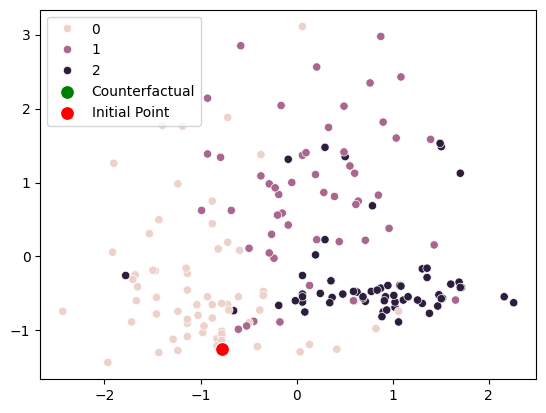

In [26]:
def plot_decision_boundaries(node, x_min, x_max, y_min, y_max, depth=0):
    if node is None or node.cluster is not None:
        return
    
    if node.feature == 0:
        plt.plot([node.threshold, node.threshold], [y_min, y_max], 'k-', lw=1)
        plot_decision_boundaries(node.left, x_min, node.threshold, y_min, y_max, depth + 1)
        plot_decision_boundaries(node.right, node.threshold, x_max, y_min, y_max, depth + 1)
    elif node.feature == 1:
        plt.plot([x_min, x_max], [node.threshold, node.threshold], 'k-', lw=1)
        plot_decision_boundaries(node.left, x_min, x_max, y_min, node.threshold, depth + 1)
        plot_decision_boundaries(node.right, x_min, x_max, node.threshold, y_max, depth + 1)

# Assuming imm_model is an instance of the imm class and has been fitted
tree = imm_model.tree

# Plot the data points
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, legend='full')
sns.scatterplot(x=[cf[0]], y=[cf[1]], color='green', s=100, label='Counterfactual')
sns.scatterplot(x=[instance[0]], y=[instance[1]], color='red', s=100, label='Initial Point')

# Plot the decision boundaries
plot_decision_boundaries(tree, X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max())

plt.show()